In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

train_path = './input/train.csv' 
test_path = './input/test.csv'
train_df = pd.read_csv(train_path,parse_dates=['activation_date'])
trainde=train_df.index

test_df = pd.read_csv(test_path,parse_dates = ['activation_date'])
testdex=test_df.index
#train_df = train_df.sort_values(by='activation_date')
# Any results you write to the current directory are saved as output.





['test.csv', 'train.csv']


In [4]:
y = train_df['deal_probability']

(array([1054761.,  118059.,   84894.,   41728.,   21969.,   13387.,
           5582.,   66292.,   86676.,   10076.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

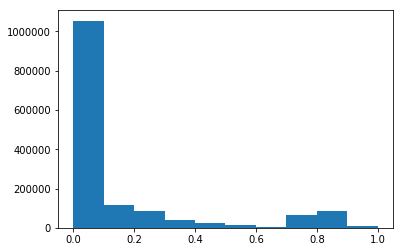

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(y)

In [6]:
#combine train and test
df = pd.concat([train_df,test_df],axis=0)
del train_df,test_df
import gc
gc.collect()

34

In [7]:

print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(-999,inplace=True)
df["image_top_1"].fillna(-999,inplace=True)


Feature Engineering


In [8]:
df.drop(["image"],axis=1,inplace=True)



In [9]:
print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","item_seq_number","user_type","image_top_1"]
print("Encoding :",categorical)


Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'item_seq_number', 'user_type', 'image_top_1']


In [10]:

from sklearn import preprocessing

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 


In [11]:
# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col] = lbl.fit_transform(df[col].astype(str))
    
print("\nText Features")

# Feature Engineering 
df['text_feat'] = df.apply(lambda row: ' '.join([
    str(row['param_1']), 
    str(row['param_2']), 
    str(row['param_3'])]),axis=1) # Group Param Features
df.drop(["param_1","param_2","param_3"],axis=1,inplace=True)



Text Features


In [12]:
# meta  text features
textfeats =['title','description','text_feat']
for col in textfeats:
    df[col] = df[col].astype('str')
    df[col] = df[col].fillna('null')
    df[col] = df[col].str.lower()
    df[col+'num_chars'] = df[col].apply(lambda comment:len(comment))
    df[col+'num_words'] = df[col].apply(lambda comment: len(comment.split()))
    df[col+'unique_words'] = df[col].apply(lambda comment: len(set(comment.split())))
    df[col+'unique_vs_num_words'] = df[col+'unique_words']/df[col+'num_words']*100

In [13]:
df.head()

,activation_date,category_name,city,deal_probability,description,image_top_1,item_id,item_seq_number,parent_category_name,price,...,titleunique_words,titleunique_vs_num_words,descriptionnum_chars,descriptionnum_words,descriptionunique_words,descriptionunique_vs_num_words,text_featnum_chars,text_featnum_words,text_featunique_words,text_featunique_vs_num_words
0,2017-03-28,42,462,0.12789,"кокон для сна малыша,пользовались меньше месяц...",13,b912c3c6a6ad,9108,4,5.991467,...,3,100.0,58,7,7,100.0,33,4,3,75.000000
1,2017-03-26,22,1314,0.00000,"стойка для одежды, под вешалки. с бутика.",2723,2dac0150717d,8389,2,8.006368,...,3,100.0,41,7,7,100.0,14,3,2,66.666667
2,2017-03-20,2,1290,0.43177,"в хорошем состоянии, домашний кинотеатр с blu ...",2260,ba83aefab5dc,32856,0,8.294050,...,2,100.0,99,17,17,100.0,35,7,6,85.714286
3,2017-03-25,42,950,0.80323,продам кресло от0-25кг,2838,02996f1dd2ea,14637,4,7.696213,...,1,100.0,22,3,3,100.0,28,4,3,75.000000
4,2017-03-16,0,318,0.20797,все вопросы по телефону.,1408,7c90be56d2ab,15299,6,10.596635,...,3,100.0,24,4,4,100.0,26,5,5,100.000000


In [14]:
stopwords_russ = stopwords.words('russian')
tfidf_params={
    'analyzer':'word',
    'tokenizer':'r\w{1,}',
    'stop_words':stopwords_russ,
    'norm':'l2'
}
def get_col(colname):
    return lambda x:x[colname]

fu = FeatureUnion([
    ('title',TfidfVectorizer(**tfidf_params, max_features=500,ngram_range=(1,2),preprocessor = get_col('title'))),
    ('description',TfidfVectorizer(**tfidf_params,ngram_range=(1,2),max_features=1500,preprocessor = get_col('description'))),
     ('text_feat',TfidfVectorizer(**tfidf_params,ngram_range=(1,2),max_features=1500,preprocessor = get_col('text_feat')))
                 ])

In [15]:
converter_title= TfidfVectorizer(analyzer='word',
                                 max_features=500,
                                 stop_words=stopwords_russ,
                                 ngram_range=(1,2),
                                 preprocessor=lambda x:x
                                )
tfidf_title= converter_title.fit_transform(df['title'])

In [15]:
converter_desc= TfidfVectorizer(analyzer='word',
                                 max_features=500,
                                 stop_words=stopwords_russ,
                                 ngram_range=(1,2),
                                 preprocessor=lambda x:x
                                )
tfidf_desc= converter_desc.fit_transform(df['description'])

In [16]:
converter_text_feat = TfidfVectorizer(analyzer='word',
                                      max_features = 500,
                                      stop_words = stopwords_russ,
                                      ngram_range=(1,2),
                                      preprocessor= lambda x:x
                                      )
tfidf_textfeat=converter_text_feat.fit_transform(df['text_feat'])

In [23]:
# 拼接各个features
traindex = trainde


In [31]:
df.drop(textfeats,axis=1,inplace=True)

In [33]:
df.drop('item_id',axis=1,inplace=True)

In [35]:
df.drop('activation_date',axis=1,inplace=True)

In [36]:
df.shape

In [41]:
df_concated  = hstack([csr_matrix(df.values),tfidf_desc,tfidf_textfeat,tfidf_title])

In [44]:
# modelling stage